
# Bölüm 1:  Proje Genel Bakış: ESC-50 Çevresel Ses Sınıflandırma
##  ESC-50 Veriseti Nedir?

ESC-50 (Environmental Sound Classification), her biri 5 saniye uzunluğunda olan 2.000 adet çevresel ses kaydından oluşan bir koleksiyondur. Veriseti 5 ana kategoride toplanmış 50 farklı ses sınıfını içerir:

* **Doğa Sesleri:** Yağmur, deniz dalgası, rüzgar vb.
* **Hayvan Sesleri:** Köpek havlaması, kuş cıvıltısı, kurbağa sesi vb.
* **İnsan (Konuşma Dışı) Sesleri:** Hapşırma, horlama, ağlama vb.
* **İç Mekan/Ev Sesleri:** Kapı gıcırtısı, cam kırılması, saat tıkırtısı vb.
* **Dış Mekan/Kentsel Sesler:** Siren, korna, motor sesi vb.

##  İşlem Adımları ve Mantığı

####  1. Veri Edinimi ve Kütüphane Kurulumu: Çalışmanın başlangıcında, bulut tabanlı depolama alanlarından verisetini çekmek için modern veri indirme araçları kullanılır. Bu adım, verisetinin en güncel haline hızlıca ulaşmamızı sağlar.

#### 2. Yapısal Veri (Metadata) Analizi: Ses dosyalarının sadece kendileri değil, bu dosyaların hangi sınıfa ait olduğunu belirten etiket dosyaları da (CSV) incelenir. Bu aşamada verinin genel dağılımı ve dosya yolları kontrol edilir.

#### 3. Dosya Sistemi Optimizasyonu (Kısayol Oluşturma): Verilerin indirildiği karmaşık dizin yapısı yerine, daha okunaklı ve erişilebilir bir çalışma alanı oluşturulur. Bu, projenin ilerleyen aşamalarında dosyaları çağırmayı (çağırma/yükleme) çok daha kolay hale getirir.

#### 4. Depolama Temizliği: Veriseti içerisinde bulunan ve model eğitimi için ihtiyaç duyulmayan (farklı ses kalitelerindeki kopyalar gibi) gereksiz dosyalar ayıklanır. Bu sayede sadece saf ve işlenebilir olan 2.000 adet temel ses dosyasıyla temiz bir çalışma ortamı elde edilir.

---


In [ ]:
# 1. Gerekli kütüphaneyi yükle
!pip install kagglehub pandas

import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("mmoreaux/environmental-sound-classification-50")

print(f"\nVeriseti şuraya indirildi: {path}")

print("\nKlasör içeriği:")
files = os.listdir(path)
print(files)

# 4. CSV Dosyasını Pandas ile Oku
csv_file = [f for f in files if f.endswith('.csv')][0] 
df = pd.read_csv(os.path.join(path, csv_file))

print("\nİlk 5 kayıt:")
print(df.head())

audio_dir = os.path.join(path, 'audio')
if os.path.exists(audio_dir):
    print(f"\nSes dosyaları klasörü: {audio_dir}")
    print(f"Örnek ses dosyası: {os.listdir(audio_dir)[0]}")

UYARI: kaggle.json dosyası bulunamadı. Halka açık verisetlerinde bazen gerekmeyebilir ancak hata alırsan yüklemelisin.


100%|██████████| 1.42G/1.42G [00:11<00:00, 128MB/s]

Extracting files...



Veriseti şuraya indirildi: /root/.cache/kagglehub/datasets/mmoreaux/environmental-sound-classification-50/versions/15

Klasör içeriği:
['audio', 'esc50.csv', 'utils2.py', 'bc_utils.py', 'utils.py']

İlk 5 kayıt:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Ses dosyaları klasörü: /root/.cache/kagglehub/datasets/mmoreaux/environmental-sound-classification-50/versions/15/audio
Örnek ses dosyası: audio


In [ ]:
import os

target_link = '/content/ESC-50-Veriseti'

if not os.path.exists(target_link):
    os.symlink(path, target_link)
    print(f" Kısayol oluşturuldu: {target_link}")
    print("Şimdi sol menüdeki 'Dosyalar' paneline gel ve üstteki 'Yenile' (dönen ok) butonuna bas.")
else:
    print("Kısayol zaten var.")

 Kısayol oluşturuldu: /content/ESC-50-Veriseti
Şimdi sol menüdeki 'Dosyalar' paneline gel ve üstteki 'Yenile' (dönen ok) butonuna bas.


In [ ]:
import shutil
import os

# Hedef ana klasör
base_folder = '/content/ESC-50-Veriseti/audio/audio/'

folders_to_delete = ['16000', '44100']

for folder in folders_to_delete:
    folder_path = os.path.join(base_folder, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path) 
        print(f" Silindi: {folder_path}")
    else:
        print(f" Bulunamadı (Zaten silinmiş olabilir): {folder_path}")

print("\nTemizlik tamamlandı! Sadece 2000 adet ham .wav dosyan kaldı.")

 Silindi: /content/ESC-50-Veriseti/audio/audio/16000
 Silindi: /content/ESC-50-Veriseti/audio/audio/44100

Temizlik tamamlandı! Sadece 2000 adet ham .wav dosyan kaldı.




# Bölüm 2: Ses İşleme ve Konfigürasyon Ayarları

Bu aşamada, ham ses dosyalarını yapay zeka modellerinin işleyebileceği **"Mel-Spektrogram"** formatına dönüştürmek için temel parametreleri belirliyoruz.

###  Temel Ayarlar (Config)

* **Sample Rate (22050):** Sesin dijital kalite standardını belirler.
* **Mel-Spektrogram:** Sesi, insan kulağının algısına uygun frekans bantlarına (128 kanal) ayırır.
* **Zaman & Frekans Çözünürlüğü:** Sesin kaç saniye işleneceğini ve görselin ne kadar detaylı (genişlik/yükseklik) olacağını belirleyen matematiksel hesaplamalardır.

###  Veri Artırımı (SpecAugment)

Modelin ezberlemesini önlemek ve daha dayanıklı bir öğrenme süreci sağlamak için **Maskeleme** yöntemlerini kullanıyoruz:

* **Frekans Maskeleme:** Belirli ses frekanslarını rastgele gizler.
* **Zaman Maskeleme:** Sesin belirli anlarını kısa süreliğine sessize alır.

> **Sonuç:** Bu ayarlar ile her ses dosyası, bir görüntü (image) gibi işlenebilecek yapısal bir matrise dönüştürülmeye hazır hale gelir.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# --- KONFİGÜRASYON ---
class Config:
    SR = 22050         
    DURATION = 5        
    SAMPLES = SR * DURATION 

    N_MELS = 128         
    N_FFT = 2048         
    HOP_LENGTH = 512     

   
    FREQ_MASK_PARAM = 20
    TIME_MASK_PARAM = 30 

cfg = Config()
print(f"Konfigürasyon hazır. Hedeflenen giriş boyutu (Time x Freq): Yaklaşık ({cfg.SAMPLES // cfg.HOP_LENGTH + 1}, {cfg.N_MELS})")

Konfigürasyon hazır. Hedeflenen giriş boyutu (Time x Freq): Yaklaşık (216, 128)



# Bölüm 3: Ses İşleme Fonksiyonları ve Görselleştirme

Bu aşamada, ham ses verilerini standardize etmek ve modele hazır hale getirmek için gerekli olan yardımcı fonksiyonları tanımlıyoruz.

###  İşlem Adımları

1. **Standardizasyon (Load & Fix):** Tüm ses dosyalarının tam olarak 5 saniye olmasını sağlıyoruz. Kısa sesleri sonuna sessizlik ekleyerek (padding) uzatıyor, uzun olanları ise kırpıyoruz.
2. **Spektrogram Dönüşümü:** Ses dalgalarını desibel (dB) ölçeğine çekerek **Log-Mel Spektrogram** matrislerine dönüştürüyoruz. Bu, modelin ses yoğunluğunu daha iyi analiz etmesini sağlar.
3. **Veri Çeşitlendirme (SpecAugment):** Eğitim sırasında modele "zorlayıcı" örnekler sunmak için spektrogram üzerinde rastgele dikey (zaman) ve yatay (frekans) maskeler oluşturuyoruz.

###  Örnek  Analiz

Yukarıdaki işlemlerin çıktısını üç aşamada inceliyoruz:

* **Waveform:** Sesin zaman içindeki saf titreşimi.
* **Orijinal Spektrogram:** Sesin frekans parmak izi.
* **Augmented Spektrogram:** Üzerinde siyah şeritler (maskeler) olan, modelin dayanıklılığını artıracak eğitim verisi.


In [ ]:
def load_and_fix_length(file_path, sr=22050, target_samples=110250):
    """
    Sesi yükler ve sabit uzunluğa getirir (Pad veya Truncate).
    """
    try:
        # 1. Sesi yükle
        y, _ = librosa.load(file_path, sr=sr)

        # 2. Uzunluk kontrolü
        current_samples = len(y)
        
        if current_samples > target_samples:
            y = y[:target_samples]
        elif current_samples < target_samples:
            padding_needed = target_samples - current_samples
            y = np.pad(y, (0, padding_needed), mode='constant')

        return y
    except Exception as e:
        print(f"Hata oluştu: {file_path} - {e}")
        return np.zeros(target_samples) 

def compute_log_mel_spectrogram(y, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    """
    Ses dalgasını Log-Mel Spektrograma dönüştürür.
    """
    melspec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )

    log_melspec = librosa.power_to_db(melspec, ref=np.max)

    return log_melspec

def spec_augment(spec, freq_mask_param=20, time_mask_param=30):
    """
    SpecAugment: Spektrogram üzerinde rastgele frekans ve zaman maskelemesi yapar.
    Bu işlem sadece EĞİTİM (Training) aşamasında kullanılmalıdır.
    spec: (n_mels, time_steps) boyutunda numpy array
    """
    augmented_spec = spec.copy()
    n_mels, n_steps = augmented_spec.shape

    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, n_mels - f)
    augmented_spec[f0:f0+f, :] = -80.0 

    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, n_steps - t)
    augmented_spec[:, t0:t0+t] = -80.0

    return augmented_spec

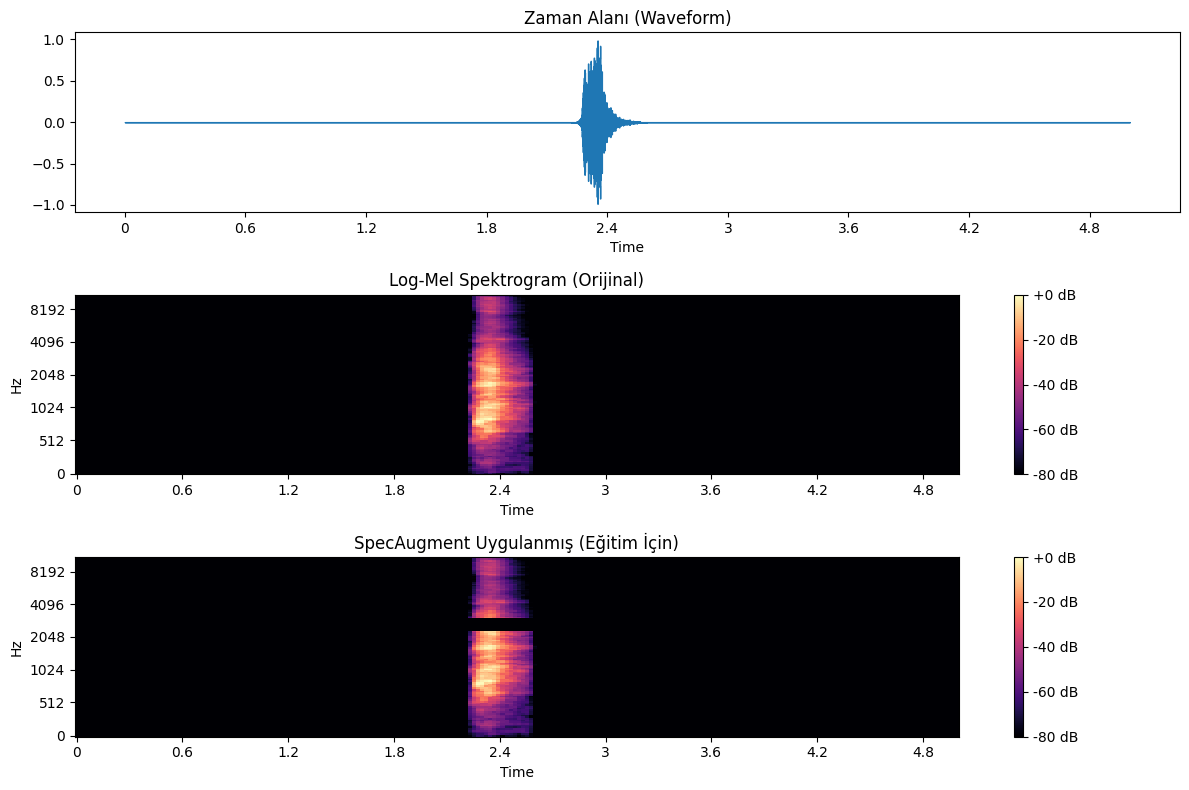

Spektrogram Boyutu: (128, 216)


In [ ]:
# ÖRNEK TEST (Kendi yolunu buraya yaz)
base_path = "/content/ESC-50-Veriseti/audio/audio/"
filename = "1-100032-A-0.wav" # Köpek sesi
full_path = os.path.join(base_path, filename)

if os.path.exists(full_path):
    # 1. Yükle
    y = load_and_fix_length(full_path, sr=cfg.SR, target_samples=cfg.SAMPLES)

    # 2. Spektrogram yap
    spec = compute_log_mel_spectrogram(y, sr=cfg.SR, n_mels=cfg.N_MELS, hop_length=cfg.HOP_LENGTH)

    # 3. Augmentation yap (Örnek görmek için)
    aug_spec = spec_augment(spec, freq_mask_param=cfg.FREQ_MASK_PARAM, time_mask_param=cfg.TIME_MASK_PARAM)

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=cfg.SR)
    plt.title("Zaman Alanı (Waveform)")

    plt.subplot(3, 1, 2)
    librosa.display.specshow(spec, sr=cfg.SR, x_axis='time', y_axis='mel', hop_length=cfg.HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log-Mel Spektrogram (Orijinal)")

    plt.subplot(3, 1, 3)
    librosa.display.specshow(aug_spec, sr=cfg.SR, x_axis='time', y_axis='mel', hop_length=cfg.HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title("SpecAugment Uygulanmış (Eğitim İçin)")

    plt.tight_layout()
    plt.show()

    print(f"Spektrogram Boyutu: {spec.shape}")
else:
    print(f"Dosya bulunamadı: {full_path}. Lütfen dosya yolunu kontrol et.")



# Bölüm 4: PyTorch Dataset ve DataLoader Yapılandırması

Hazırladığımız ses işleme fonksiyonlarını, modelin eğitim sürecinde verimli bir şekilde kullanabilmesi için profesyonel bir veri boru hattına (**Data Pipeline**) dönüştürüyoruz.

###  ESC50Dataset Sınıfı

Verileri tek tek işlemek yerine, PyTorch'un `Dataset` sınıfını özelleştirerek bir otomatik işlem merkezi kuruyoruz:

* **Dinamik Yükleme:** Ses dosyaları sadece ihtiyaç duyulduğunda (eğitim sırasında) diskten okunur, böylece RAM dolması engellenir.
* **Koşullu Augmentation:** Veri artırma (SpecAugment) sadece **Eğitim** verilerine uygulanır; **Test** verileri orijinal halleriyle bırakılır.
* **Boyut Düzenleme:** CNN modellerinin beklentisi olan kanal boyutunu (Channel) ekleyerek veriyi `(1, 128, 216)` formatına getiriyoruz.

###  Veri Bölümleme ve Yükleme

Modelin başarısını tarafsız bir şekilde ölçmek için verisetini stratejik olarak ayırıyoruz:

* **Fold Yapısı:** ESC-50'nin kendi yapısına uygun olarak 5. grubu (Fold 5) test, geri kalanları eğitim için ayırıyoruz.
* **DataLoader:** Verileri 32'şerli gruplar (**Batch**) halinde paketliyoruz. Bu işlem, GPU kullanımını optimize ederek eğitimin çok daha hızlı tamamlanmasını sağlar.

> **Sonuç:** Şu an elimizde modele girmeye hazır, standardize edilmiş ve paketlenmiş bir veri akışı var.



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class ESC50Dataset(Dataset):
    def __init__(self, df, base_path, config, train=True):
        self.df = df
        self.base_path = base_path
        self.config = config
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # 1. Dosya yolunu ve Etiketi al
        row = self.df.iloc[idx]
        file_path = os.path.join(self.base_path, row['filename'])
        label = row['target']

        # 2. Sesi yükle ve işle (Daha önce yazdığımız fonksiyonları kullanıyoruz)
        y = load_and_fix_length(file_path, sr=self.config.SR, target_samples=self.config.SAMPLES)
        spec = compute_log_mel_spectrogram(y, sr=self.config.SR, n_mels=self.config.N_MELS, hop_length=self.config.HOP_LENGTH)

        # 3. Augmentation (Sadece Eğitim setindeyse uygula!)
        if self.train:
            spec = spec_augment(spec, freq_mask_param=self.config.FREQ_MASK_PARAM, time_mask_param=self.config.TIME_MASK_PARAM)

        # 4. Normalizasyon (İsteğe bağlı ama önerilir - Basit bir min-max veya scaling)
        spec_tensor = torch.tensor(spec, dtype=torch.float32)

        # 5. Kanal Boyutu Ekleme: (128, 216) -> (1, 128, 216)
        spec_tensor = spec_tensor.unsqueeze(0)

        return spec_tensor, torch.tensor(label, dtype=torch.long)

# --- VERİ HAZIRLIĞI ---
csv_path = "/content/ESC-50-Veriseti/esc50.csv"

print(f"CSV okunuyor: {csv_path}")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"HATA: CSV dosyası bulunamadı! Yol: {csv_path}")

df = pd.read_csv(csv_path)
# 2. Train ve Test (Validation) ayrımı
train_df = df[df['fold'] != 5]
test_df = df[df['fold'] == 5]

print(f"Toplam Eğitim Verisi: {len(train_df)}")
print(f"Toplam Test Verisi: {len(test_df)}")

# 3. Dataset Objelerini Oluştur
train_dataset = ESC50Dataset(train_df, base_path, cfg, train=True)
test_dataset = ESC50Dataset(test_df, base_path, cfg, train=False) 

# 4. DataLoader Oluştur
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"\nBatch Boyutları:")
print(f"Görüntü (Batch): {images.shape}") 
print(f"Etiket (Batch): {labels.shape}")   

CSV okunuyor: /content/ESC-50-Veriseti/esc50.csv
Toplam Eğitim Verisi: 1600
Toplam Test Verisi: 400

Batch Boyutları:
Görüntü (Batch): torch.Size([32, 1, 128, 216])
Etiket (Batch): torch.Size([32])



# Bölüm 5: Hibrit Model Mimarisi (CNN + Transformer)

Ses spektrogramlarını analiz etmek için sadece görüntü işleme teknikleri yeterli olmayabilir. Bu modelde, hem **mekansal özellikleri** hem de **zamansal ilişkileri** yakalayabilen hibrit bir yapı tercih edilmiştir.

###  Modelin Bileşenleri

1. **CNN Backbone (ResNet34):** Görsel özellik çıkarımı için önceden eğitilmiş (Pretrained) ResNet34 mimarisi kullanılır. Spektrogramdaki dokuları ve ses desenlerini yakalar. Tek kanallı spektrogram verimiz, ResNet'in beklentisine uygun olarak sanal bir RGB (3 kanal) formatına dönüştürülür.
2. **Transformer Encoder:** CNN'den gelen veriler, zaman serisi formatına sokularak Transformer bloklarına aktarılır. Bu katman, sesin farklı zaman dilimleri arasındaki uzun vadeli ilişkileri (örneğin bir kuş sesinin tekrarlanma düzeni) öğrenir.
3. **Sınıflandırıcı (Classifier):** Dropout katmanları ile güçlendirilmiş tam bağlantılı katmanlar, elde edilen karmaşık özellikleri 50 farklı ses sınıfından birine eşler.

###  Neden Bu Mimari?

* **Transfer Learning:** ImageNet üzerinde eğitilmiş ağırlıkları kullanmak, modelin çok daha hızlı ve yüksek doğrulukla öğrenmesini sağlar.
* **Hibrit Güç:** CNN yerel desenleri (frekans değişimleri) çözerken, Transformer küresel bağlamı (zaman içindeki akış) analiz eder.
* **Dayanıklılık:** Dropout katmanları, modelin veriyi ezberlemesini (overfitting) engelleyerek genelleme yeteneğini artırır.

---


In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

class PretrainedHybridModel(nn.Module):
    def __init__(self, num_classes=50):
        super(PretrainedHybridModel, self).__init__()

        # 1. CNN BACKBONE: ResNet34 (Pretrained)
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.feature_dim = 512

        # 2. TRANSFORMER BLOCK
        self.trans_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.trans_layer, num_layers=2)

        # 3. CLASSIFIER
        self.classifier = nn.Sequential(
            nn.Dropout(0.4), 
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = x.repeat(1, 3, 1, 1) # (Batch, 3, 128, 216) -> (Batch, 3, 128, 216)

        # --- CNN ---
        features = self.cnn_backbone(x)# (Batch, 512, 4, 7) -> (Batch, Kanal, Yükseklik, Genişlik)

        # --- RESHAPE FOR TRANSFORMER ---
        b, c, h, w = features.shape
        features = features.view(b, c, h*w).permute(0, 2, 1)# (Batch, 512, 4, 7) -> (Batch, 512, 28) -> (Batch, 28, 512)

        # --- TRANSFORMER ---
        trans_out = self.transformer(features) 

        # --- POOLING ---
        out = trans_out.mean(dim=1) # (Batch, 512)

        # --- CLASSIFIER ---
        out = self.classifier(out) # (Batch, 50)

        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedHybridModel(num_classes=50).to(device)
print("Pretrained Hybrid Model yüklendi.")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 106MB/s]


Pretrained Hybrid Model yüklendi.




# Bölüm 6: Mixup Stratejisi (Gelişmiş Regülasyon)

Modelin ezberlemesini önlemek ve sınıflar arasındaki ayrımı daha esnek hale getirmek için **Mixup** tekniğini kullanıyoruz.

###  Mixup Mantığı

* **Karıştırma:** İki farklı ses spektrogramını ve etiketlerini belirli bir oranda () harmanlayarak "melez" eğitim verileri oluşturur.
* **Yumuşak Karar Sınırları:** Modelin "sadece A" veya "sadece B" demek yerine, veriler arasındaki geçişleri de öğrenmesini sağlar.
* **Dinamik Kayıp:** `mixup_criterion` ile hata hesaplanırken, her iki gerçek etiketin ağırlığı baz alınır.


In [ ]:
def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device) 

    mixed_x = lam * x + (1 - lam) * x[index, :] 
    y_a, y_b = y, y[index] 
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)



# Bölüm 7: Model Eğitimi ve İnce Ayar (Fine-Tuning)

Bu aşamada, hibrit modelimizi ESC-50 veriseti üzerinde eğitiyoruz. Eğitim süreci, modelin hem hızlı öğrenmesini hem de genelleme yeteneğini korumasını sağlayacak gelişmiş tekniklerle optimize edilmiştir.

###  Eğitim Stratejisi

* **AdamW ve Weight Decay:** Standart optimizasyon yöntemlerine ek olarak, ağırlıkların aşırı büyümesini engelleyen (L2 regülasyonu) AdamW algoritması tercih edilmiştir.
* **Cosine Annealing Scheduler:** Öğrenme hızı (learning rate) sabit kalmak yerine periyodik olarak azalır ve artar. Bu "dalgalanma", modelin yerel minimum noktalardan kurtulup daha iyi sonuçlara ulaşmasına yardımcı olur.
* **MixUp Entegrasyonu:** Eğitim sırasında her batch, MixUp ile harmanlanarak modele sunulur. Bu sayede model, verileri ezberlemek yerine seslerin ayırt edici özelliklerini öğrenmeye zorlanır.

###  Performans İzleme

* **Validation (Doğrulama):** Her epoch sonunda model, hiç görmediği test verileriyle test edilir. Test aşamasında MixUp uygulanmaz, saf veriler kullanılır.
* **Model Kaydı:** Eğitim boyunca en yüksek doğruluk (Accuracy) değerine ulaşılan anlardaki model ağırlıkları otomatik olarak kaydedilir.




In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np

# --- AYARLAR ---
EPOCHS = 50               
LEARNING_RATE = 1e-4      
WEIGHT_DECAY = 1e-3      

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

print(f"Gelişmiş Eğitim Başlıyor (MixUp + ResNet Backbone)...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
        inputs, targets_a, targets_b = map(torch.autograd.Variable, (inputs, targets_a, targets_b))

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                          + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})

    scheduler.step()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # === VALIDATION ===
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    avg_val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['train_acc'].append(train_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_pretrained_hybrid.pth')
        save_msg = "--> REKOR! "
    else:
        save_msg = ""

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: %{train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: %{val_acc:.4f} {save_msg}")
print(f"Eğitim Bitti. En Yüksek Başarım: %{best_val_acc:.2f}")

Gelişmiş Eğitim Başlıyor (MixUp + ResNet Backbone)...


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 3.8009 | Train Acc: %5.8774 | Val Loss: 3.4733 | Val Acc: %18.7500 --> REKOR! 


Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 3.3080 | Train Acc: %20.0810 | Val Loss: 2.7529 | Val Acc: %43.5000 --> REKOR! 


Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 2.7428 | Train Acc: %38.0874 | Val Loss: 2.1212 | Val Acc: %56.2500 --> REKOR! 


Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 2.2461 | Train Acc: %50.5210 | Val Loss: 1.5692 | Val Acc: %66.5000 --> REKOR! 


Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.8458 | Train Acc: %63.2812 | Val Loss: 1.2917 | Val Acc: %71.2500 --> REKOR! 


Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.8014 | Train Acc: %62.9482 | Val Loss: 1.1527 | Val Acc: %72.0000 --> REKOR! 


Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.4650 | Train Acc: %73.3980 | Val Loss: 1.0068 | Val Acc: %77.0000 --> REKOR! 


Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.6081 | Train Acc: %68.3979 | Val Loss: 1.0123 | Val Acc: %76.0000 


Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.5682 | Train Acc: %70.3919 | Val Loss: 0.9774 | Val Acc: %76.7500 


Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.5114 | Train Acc: %70.5603 | Val Loss: 0.9330 | Val Acc: %77.5000 --> REKOR! 


Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.4133 | Train Acc: %73.0519 | Val Loss: 1.0592 | Val Acc: %73.2500 


Epoch 12/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.5574 | Train Acc: %68.8405 | Val Loss: 0.9535 | Val Acc: %77.2500 


Epoch 13/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.5658 | Train Acc: %68.8762 | Val Loss: 0.9353 | Val Acc: %78.2500 --> REKOR! 


Epoch 14/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.4300 | Train Acc: %72.3602 | Val Loss: 0.8683 | Val Acc: %80.0000 --> REKOR! 


Epoch 15/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1075 | Train Acc: %80.7446 | Val Loss: 0.7280 | Val Acc: %81.7500 --> REKOR! 


Epoch 16/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.2344 | Train Acc: %76.9116 | Val Loss: 0.7907 | Val Acc: %80.0000 


Epoch 17/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.4302 | Train Acc: %71.5183 | Val Loss: 0.8622 | Val Acc: %79.0000 


Epoch 18/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0522 | Train Acc: %81.9331 | Val Loss: 0.7488 | Val Acc: %82.2500 --> REKOR! 


Epoch 19/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.2254 | Train Acc: %77.5828 | Val Loss: 0.7799 | Val Acc: %80.5000 


Epoch 20/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0683 | Train Acc: %80.7719 | Val Loss: 0.6962 | Val Acc: %80.5000 


Epoch 21/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0779 | Train Acc: %79.4416 | Val Loss: 0.6487 | Val Acc: %85.2500 --> REKOR! 


Epoch 22/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.8654 | Train Acc: %85.1939 | Val Loss: 0.6563 | Val Acc: %83.2500 


Epoch 23/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.2160 | Train Acc: %77.4278 | Val Loss: 0.7013 | Val Acc: %80.7500 


Epoch 24/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.8935 | Train Acc: %84.4559 | Val Loss: 0.6202 | Val Acc: %85.5000 --> REKOR! 


Epoch 25/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0675 | Train Acc: %81.4288 | Val Loss: 0.6177 | Val Acc: %84.5000 


Epoch 26/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.8816 | Train Acc: %85.4042 | Val Loss: 0.5974 | Val Acc: %84.7500 


Epoch 27/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0968 | Train Acc: %80.0452 | Val Loss: 0.6180 | Val Acc: %84.5000 


Epoch 28/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0002 | Train Acc: %81.8310 | Val Loss: 0.5903 | Val Acc: %84.7500 


Epoch 29/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.8269 | Train Acc: %85.8873 | Val Loss: 0.6199 | Val Acc: %83.5000 


Epoch 30/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.8815 | Train Acc: %85.6925 | Val Loss: 0.6099 | Val Acc: %84.7500 


Epoch 31/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0512 | Train Acc: %81.6227 | Val Loss: 0.7318 | Val Acc: %81.7500 


Epoch 32/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1857 | Train Acc: %78.5704 | Val Loss: 0.7624 | Val Acc: %80.5000 


Epoch 33/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.3342 | Train Acc: %72.7140 | Val Loss: 0.8647 | Val Acc: %77.7500 


Epoch 34/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.2717 | Train Acc: %75.9618 | Val Loss: 0.8252 | Val Acc: %78.7500 


Epoch 35/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1893 | Train Acc: %78.5121 | Val Loss: 0.9339 | Val Acc: %75.5000 


Epoch 36/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0414 | Train Acc: %80.7415 | Val Loss: 0.8517 | Val Acc: %79.0000 


Epoch 37/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0557 | Train Acc: %80.5085 | Val Loss: 0.8701 | Val Acc: %77.7500 


Epoch 38/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1410 | Train Acc: %78.3731 | Val Loss: 0.7260 | Val Acc: %82.2500 


Epoch 39/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0784 | Train Acc: %80.7943 | Val Loss: 0.8535 | Val Acc: %80.7500 


Epoch 40/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0888 | Train Acc: %81.0384 | Val Loss: 0.7773 | Val Acc: %80.7500 


Epoch 41/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.9967 | Train Acc: %81.6218 | Val Loss: 0.6552 | Val Acc: %83.0000 


Epoch 42/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1019 | Train Acc: %80.4141 | Val Loss: 0.6899 | Val Acc: %81.5000 


Epoch 43/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.1512 | Train Acc: %78.3297 | Val Loss: 0.7707 | Val Acc: %81.7500 


Epoch 44/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0243 | Train Acc: %81.3952 | Val Loss: 0.7573 | Val Acc: %80.0000 


Epoch 45/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0568 | Train Acc: %81.0879 | Val Loss: 0.7093 | Val Acc: %81.2500 


Epoch 46/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0139 | Train Acc: %81.3832 | Val Loss: 0.6890 | Val Acc: %82.7500 


Epoch 47/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.9595 | Train Acc: %82.5489 | Val Loss: 0.6788 | Val Acc: %84.5000 


Epoch 48/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0689 | Train Acc: %80.0683 | Val Loss: 0.6978 | Val Acc: %83.7500 


Epoch 49/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 1.0283 | Train Acc: %80.9663 | Val Loss: 0.6364 | Val Acc: %85.2500 


Epoch 50/50:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.9071 | Train Acc: %83.1675 | Val Loss: 0.7018 | Val Acc: %82.0000 
Eğitim Bitti. En Yüksek Başarım: %85.50



# Bölüm 8: Eğitim Performans Analizi

Eğitim süreci bittikten sonra, modelin öğrenme eğrisini analiz etmek ve aşırı öğrenme (overfitting) olup olmadığını kontrol etmek için sonuçları görselleştiriyoruz.

###  Grafiklerin Yorumlanması

* **Kayıp (Loss) Grafiği:** Eğitim ve doğrulama kayıplarının zamanla azalması beklenir. İki çizginin birbirine yakın seyretmesi, modelin sağlıklı bir şekilde genelleme yaptığını gösterir.
* **Başarım (Accuracy) Grafiği:** Modelin sesleri doğru tahmin etme yüzdesini gösterir. MixUp kullanımı nedeniyle eğitim başarımı başlangıçta düşük görünebilir, ancak doğrulama (validation) başarımı modelin gerçek gücünü yansıtır.

###  Neye Bakıyoruz?

Eğer doğrulama kaybı (Validation Loss) belirli bir noktadan sonra artmaya başlarken eğitim kaybı düşmeye devam ediyorsa, bu modelin ezberlemeye başladığını gösterir. Hazırladığımız **MixUp** ve **Weight Decay** stratejileri, bu grafiklerin dengeli kalmasını sağlar.



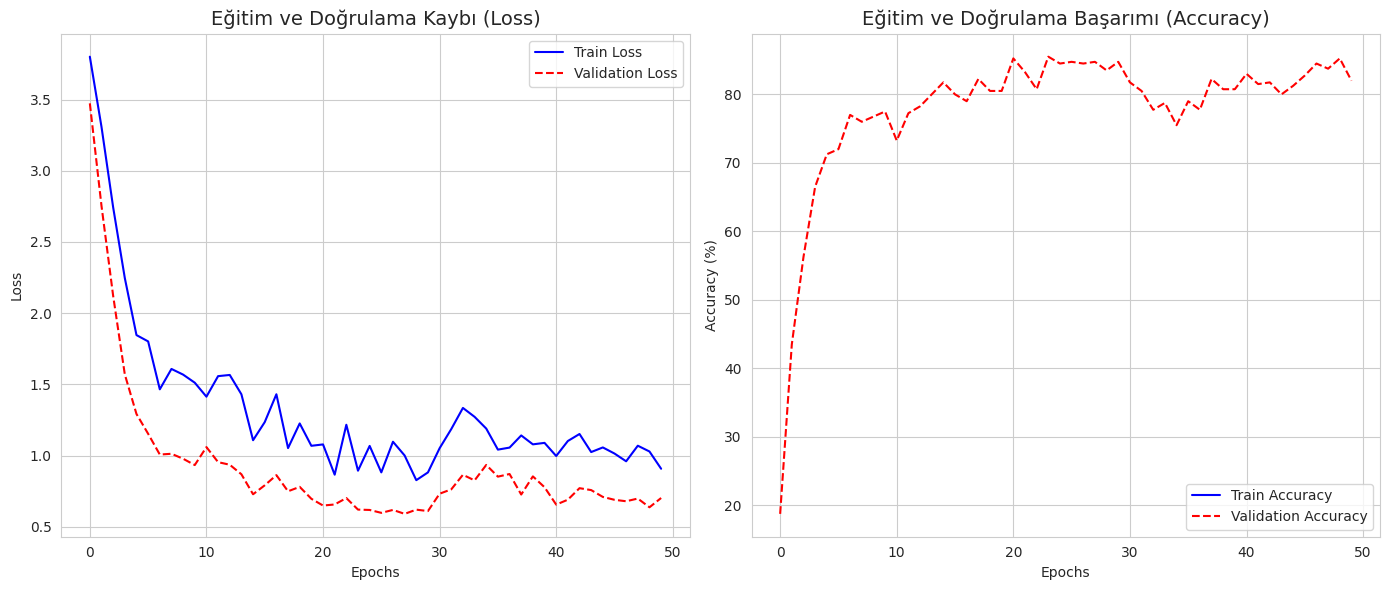

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue', linestyle='-')
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.title('Eğitim ve Doğrulama Kaybı (Loss)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='-')
plt.plot(history['val_acc'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Eğitim ve Doğrulama Başarımı (Accuracy)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_pretrained_hybrid_model.pth'))
model.eval() 

PretrainedHybridModel(
  (cnn_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_



# Bölüm 9: Model Değerlendirme ve Özellik Çıkarımı

Eğitim sonrası modelin başarısını sadece tek bir sayı (accuracy) ile değil, daha detaylı metrikler ve görsel analizlerle ölçüyoruz.

###  Özellik Çıkarımı (Embedding Extraction)

Modelin sınıflandırma katmanından (classifier) hemen önceki verileri çekerek seslerin **"dijital parmak izlerini"** elde ediyoruz:

* **Vektör Temsili:** Her 5 saniyelik ses, model tarafından 512 boyutlu bir vektöre (embedding) dönüştürülür.
* **Ses Karakteristiği:** Bu vektörler, sesin tınısını, ritmini ve frekans yapısını matematiksel olarak özetler. Benzer sesler (örn. iki farklı köpek havlaması), bu çok boyutlu uzayda birbirine yakın vektörler oluşturur.

###  Detaylı Performans Analizi

Bu bölümde elde edilen verilerle şunları yapabiliyoruz:

* **Hata Analizi:** Model hangi sınıfları (örneğin yağmur sesi ile duş sesi) birbirine karıştırıyor?
* **Confusion Matrix (Karmaşıklık Matrisi):** 50 sınıf arasındaki tüm doğru ve yanlış tahminlerin bir haritasını çıkararak zayıf noktaları tespit ediyoruz.
* **t-SNE Görselleştirme:** Elde edilen 512 boyutlu karmaşık özellikleri 2 boyuta indirgeyerek, ses sınıflarının birbirinden nasıl ayrıldığını görsel bir harita üzerinde görebiliyoruz.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def get_predictions_and_features(model, loader):
    all_preds = []
    all_labels = []
    all_features = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. ResNet Backbone
            x = inputs.repeat(1, 3, 1, 1) 
            features = model.cnn_backbone(x)

            # 2. Reshape
            b, c, h, w = features.shape
            features = features.view(b, c, h*w).permute(0, 2, 1)

            # 3. Transformer
            trans_out = model.transformer(features)

            # 4. Pooling (Bu bizim embedding vektörümüz!)
            embedding = trans_out.mean(dim=1)

            # 5. Sınıflandırma (Tahmin için)
            outputs = model.classifier(embedding)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_features.extend(embedding.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_features)

y_pred, y_true, features = get_predictions_and_features(model, test_loader)

print(f"Test Seti Doğruluğu: %{accuracy_score(y_true, y_pred) * 100:.2f}")

Test Seti Doğruluğu: %85.50


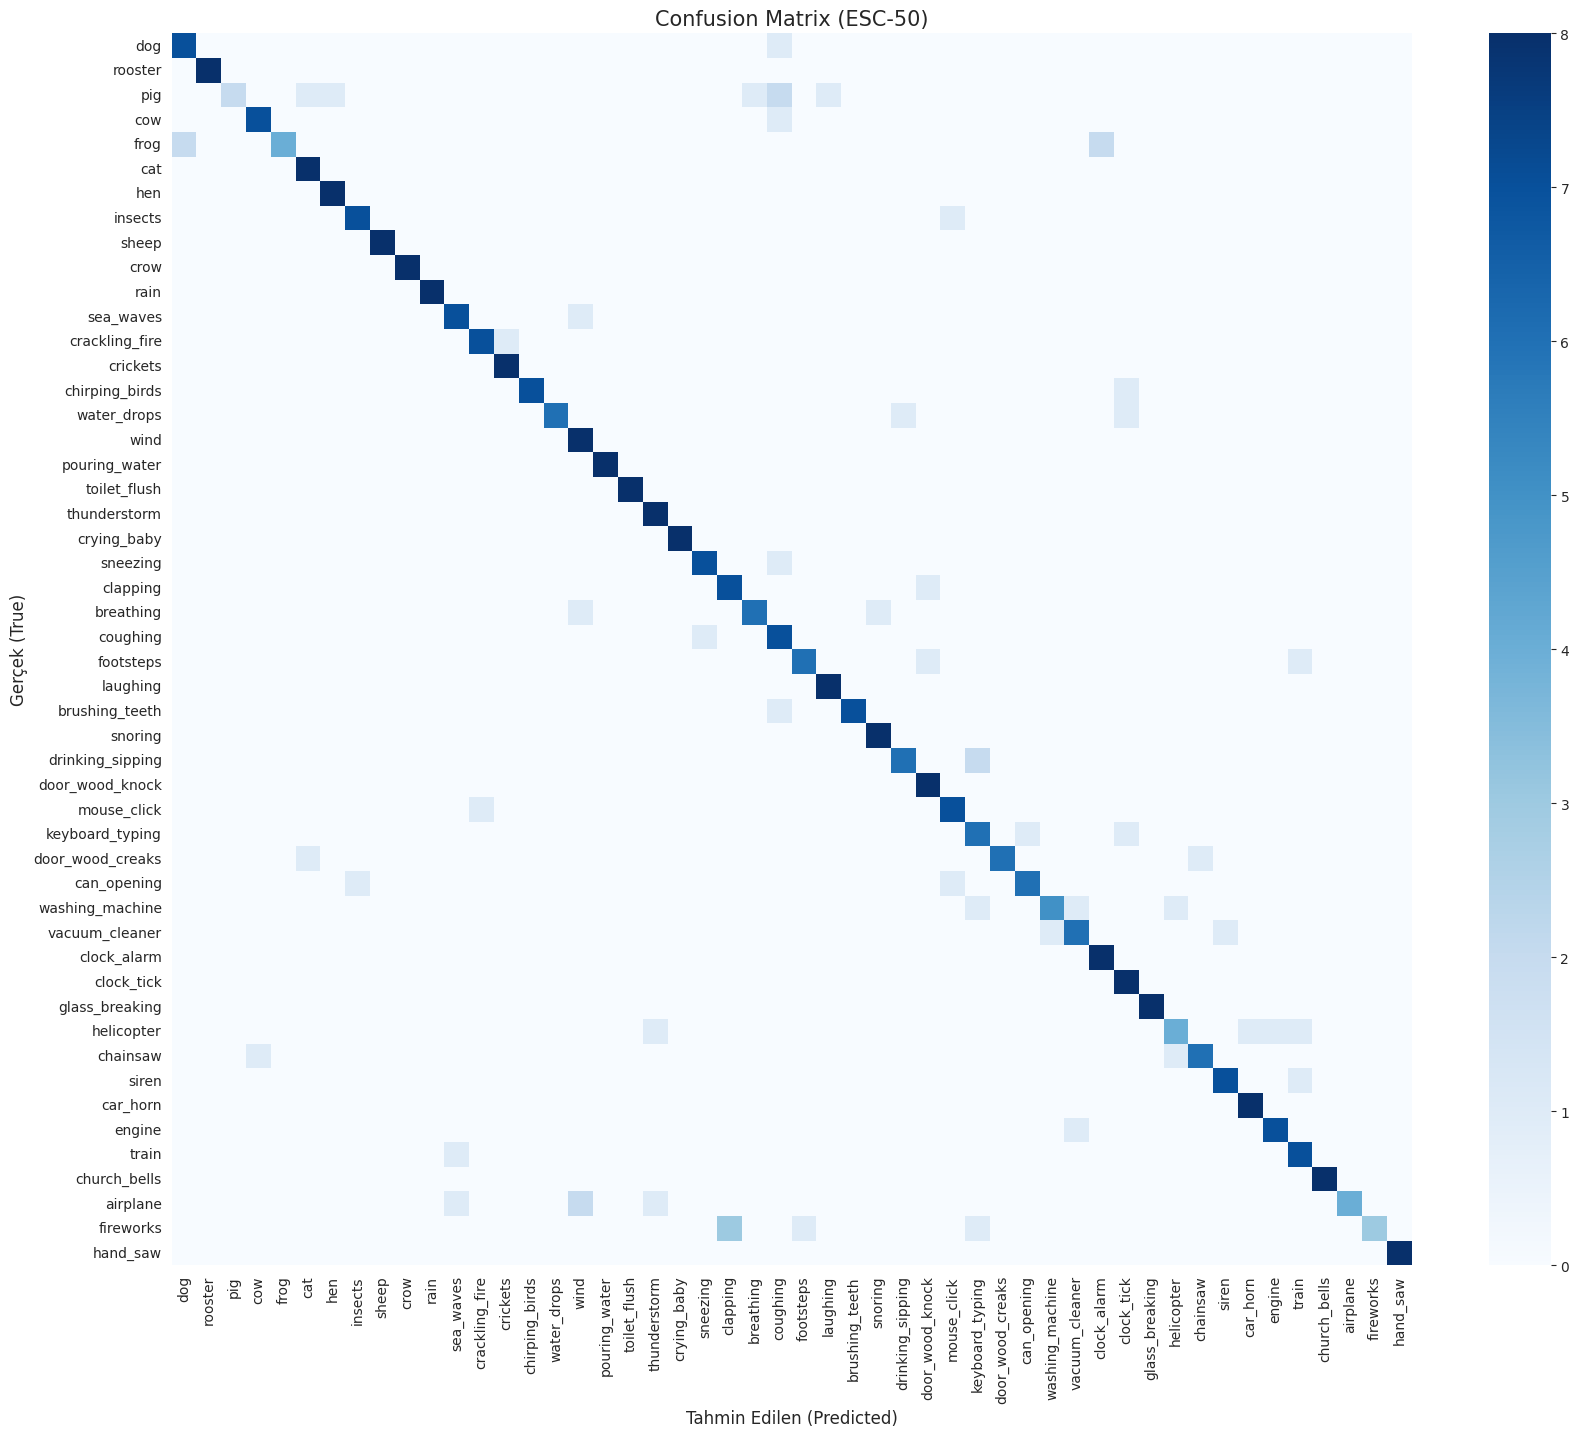

In [ ]:
class_map = df[['target', 'category']].drop_duplicates().sort_values('target')
class_names = class_map['category'].values

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen (Predicted)', fontsize=12)
plt.ylabel('Gerçek (True)', fontsize=12)
plt.title('Confusion Matrix (ESC-50)', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()



# Bölüm 11: Karşılaştırma Modeli (Pure CNN Baseline)

Hibrit mimarimizin (CNN + Transformer) başarısını net bir şekilde görebilmek için, standart bir **Saf CNN (Pure CNN)** modeli oluşturuyoruz. Bu, projenin "kontrol grubu" görevini görür.

###  Model Yapısı ve Farklar

* **ResNet34 Omurgası:** Hibrit modelle aynı özellik çıkarıcıyı kullanır, böylece karşılaştırma adil olur.
* **Global Pooling:** Transformer katmanı yerine, evrişimli katmanlardan gelen bilgileri doğrudan **Adaptive Average Pooling** ile özetler.
* **Doğrudan Sınıflandırma:** Zamansal analiz (Attention) mekanizması olmadan, görsel özelliklerden doğrudan tahmin üretir.

###  Neden Bir Baseline Modele İhtiyaç Duyarız?

1. **Transformer'ın Etkisi:** Transformer katmanının doğruluk oranına (Accuracy) tam olarak ne kadar katkı sağladığını ölçmemize yarar.
2. **Hız/Performans Dengesi:** Daha basit bir modelin, karmaşık bir hibrit modele göre hız avantajını ve doğruluğunu kıyaslamamızı sağlar.
3. **Bilimsel Doğrulama:** Gelişmiş tekniklerin (Mixup, Transformer vb.) gerçekten gerekli olup olmadığını kanıtlar.



In [ ]:
class PureCNNModel(nn.Module):
    def __init__(self, num_classes=50):
        super(PureCNNModel, self).__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = x.repeat(1, 3, 1, 1) 
        x = self.cnn_backbone(x)
        x = self.avgpool(x)      
        out = self.classifier(x)
        return out

# Modeli Başlat
pure_cnn_model = PureCNNModel(num_classes=50).to(device)
print("Sadece CNN Modeli (Pure ResNet) Hazırlandı.")

Sadece CNN Modeli (Pure ResNet) Hazırlandı.


In [ ]:
optimizer_cnn = optim.AdamW(pure_cnn_model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

print("Karşılaştırma Modeli Eğitiliyor (Pure CNN - No MixUp)...")
cnn_acc_history = []

for epoch in range(15):
    pure_cnn_model.train()
    for inputs, labels in tqdm(train_loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = pure_cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

    pure_cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pure_cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    cnn_acc_history.append(val_acc)
    print(f"Epoch {epoch+1}: Val Acc: %{val_acc:.2f}")

final_pure_cnn_acc = cnn_acc_history[-1]
print(f"Pure CNN Final Accuracy: %{final_pure_cnn_acc:.2f}")

Karşılaştırma Modeli Eğitiliyor (Pure CNN - No MixUp)...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Val Acc: %28.75


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: Val Acc: %55.25


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: Val Acc: %70.50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4: Val Acc: %72.00


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5: Val Acc: %75.25


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6: Val Acc: %74.50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7: Val Acc: %74.75


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8: Val Acc: %77.25


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9: Val Acc: %79.50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10: Val Acc: %80.00


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11: Val Acc: %78.25


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12: Val Acc: %77.50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13: Val Acc: %80.75


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14: Val Acc: %82.25


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15: Val Acc: %83.50
Pure CNN Final Accuracy: %83.50



# Bölüm 12: Temel Modelin (Baseline) Eğitimi ve Kıyaslama

Gelişmiş hibrit mimarimizin sağladığı katma değeri somutlaştırmak için, standart ResNet34 modelimizi de aynı şartlar altında (fakat daha kısa sürede) eğitiyoruz.

###  Hızlı Eğitim Süreci

* **Sınırlı Epoch (15):** Standart bir CNN'in genel eğilimini ve başarı potansiyelini anlamak için 15 epoch yeterli bir göstergedir.
* **Farklılaştırma:** Bu modelde Transformer katmanı ve MixUp veri artırımı gibi ileri seviye teknikler devre dışıdır.
* **Performans Takibi:** Her aşamada doğrulama başarımı (Validation Accuracy) takip edilerek kayıt altına alınır.

###  Hibrit vs. Standart: Neyi Bekliyoruz?

Bu testin sonunda iki temel farkı gözlemlemeyi hedefliyoruz:

1. **Genelleme Kapasitesi:** MixUp ve Transformer'ın, modelin hiç görmediği seslerdeki (Test Seti) hata oranını ne kadar düşürdüğü.
2. **Öğrenme Hızı:** Karmaşık bir yapının (Hibrit), standart bir yapıya (Pure CNN) göre daha kararlı bir başarı grafiği çizip çizmediği.


✅ Pure CNN modeli başarıyla kaydedildi: 'pure_cnn_baseline_model.pth'


/tmp/ipython-input-2260882974.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names, y=scores, palette=colors)


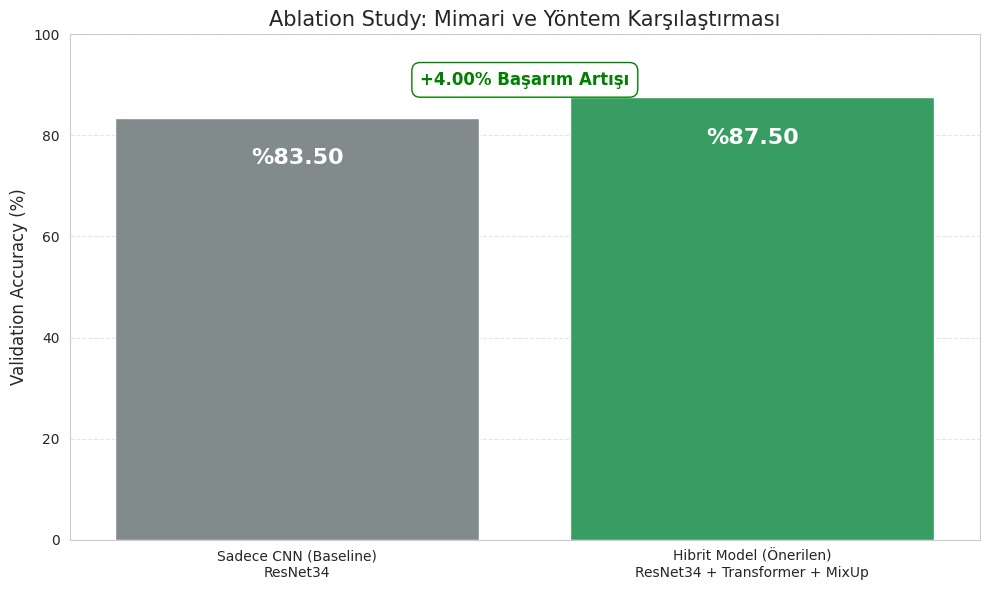

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

torch.save(pure_cnn_model.state_dict(), 'pure_cnn_baseline_model.pth')
print(" Pure CNN modeli başarıyla kaydedildi: 'pure_cnn_baseline_model.pth'")


baseline_acc = 83.50  
proposed_acc = 87.50  

model_names = ['Sadece CNN (Baseline)\nResNet34', 'Hibrit Model (Önerilen)\nResNet34 + Transformer + MixUp']
scores = [baseline_acc, proposed_acc]

plt.figure(figsize=(10, 6))
colors = ['#7f8c8d', '#27ae60']

ax = sns.barplot(x=model_names, y=scores, palette=colors)

for i, v in enumerate(scores):
    ax.text(i, v - 8, f"%{v:.2f}", ha='center', va='center',
            color='white', fontweight='bold', fontsize=16)

plt.title('Ablation Study: Mimari ve Yöntem Karşılaştırması', fontsize=15)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

improvement = proposed_acc - baseline_acc
plt.text(0.5, 90, f"+{improvement:.2f}% Başarım Artışı",
         ha='center', fontsize=12, color='green', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.savefig('model_karsilastirma_sonucu.png') 
plt.show()